Intention to quit smoking were recorded in:
- online screening and follow up
- 1st and last EEG session
- every 3 days

!!! online screening is taken from participant recruitment sheet

In [1]:
library(tidyverse)
library(here)
library(lubridate)

#get filepaths

#eff_evening_filepath = here("Every3days")

cond_file = "~/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/expe_condition_final.csv"


save_figure = here::here("Figures")

#read files

files_eff_eve <-dir(path=here::here("data/Every3days") , pattern = "*.csv") 
files_eff_bf <-dir(path=here::here("data/BaselineFollowup") , pattern = "*.csv") 
files_eff_online<-dir(path=here::here("data/OnlineFollowup") , pattern = "*.csv") 
files_eff_base_online<-dir(path=here::here("data/OnlineBaseline") , pattern = "baseline_smoking_quit.csv") # sheet with screening ID
files_study_id<-dir(path=here::here("data/OnlineBaseline") , pattern = "study_ids_online.csv") # sheet with screening_id/study_ids corresponsdence
files_qualtrics<-dir(path=here::here("data/OnlineBaseline") , pattern = "qualtrics.csv") # sheet with screening_id/study_ids corresponsdence

every3days_scores <-read.csv(here::here("data/Every3days", files_eff_eve), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)


baseline_followup_eeg <-read.csv(here::here("data/BaselineFollowup", files_eff_bf), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

followup_online <-read.csv(here::here("data/OnlineFollowup", files_eff_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

baseline_online <-read.csv(here::here("data/OnlineBaseline", files_eff_base_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
study_id <-read.csv(here::here("data/OnlineBaseline",files_study_id), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
qualtrics <-read.csv(here::here("data/OnlineBaseline",files_qualtrics), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)


# condition file
cond <- read_csv(cond_file)

#Associate online pp baseline efficacy score with their study id:

#select only screening ID and qualtrics ID on recruitment file
pp_ids<-baseline_online %>% select("Screening.ID", "Response.ID") 

qualtrics<-rename(qualtrics, Response.ID = ResponseId)


remove(baseline_online)

baseline_online<-left_join(pp_ids, qualtrics, by= 'Response.ID')

# join with study id
baseline_online <- left_join(study_id, baseline_online)

# remove screening id
baseline_online<-select(baseline_online, -Screening.ID)

#rename columns 
#- questions scoring: 0 = not at all; 100 = very much

every3days_scores<-rename(every3days_scores , date=EndDate, completed=Finished,
                  ID = Q1, 
                  QuitInt= Q5
                  )

every3days_scores$ID<-as.factor(every3days_scores$ID)


baseline_followup_eeg <-rename(baseline_followup_eeg, date=EndDate, completed=Finished,
                  ID = Q1, 
                  QuitInt= Q3
                  )

baseline_followup_eeg$ID<-as.factor(baseline_followup_eeg$ID)


followup_online<-rename(followup_online, date=EndDate, completed=Finished, 
                      ID= Q1, 
                      QuitInt=Q3 
                       )
followup_online$ID<-as.factor(followup_online$ID)

baseline_online<-rename(baseline_online, date=EndDate, completed=Finished, 
                       ID= Study.ID, 
                      QuitInt= Q75
                           )
            
baseline_online$ID<-as.factor(baseline_online$ID)

# add a "session" column
every3days_scores <- add_column(every3days_scores, "type" = "every3days")
followup_online <- add_column(followup_online, "type" = "followup")
baseline_online<- add_column(baseline_online, "type" = "baseline")

# remove extra header
#baseline_followup_eeg<-tail(baseline_followup_eeg, -2)

# create session based on occurrence of ID 
baseline_followup_eeg<-baseline_followup_eeg %>% 
        #mutate(date=ymd_hms(baseline_followup_eeg$date))  %>% 
        group_by(ID)  %>%   
        mutate('type'= row_number()) %>% 
        ungroup()
        
# assign factor and recode        
baseline_followup_eeg$type<-as.factor(baseline_followup_eeg$type)        
baseline_followup_eeg$type<-recode(baseline_followup_eeg$type, '1'="baseline", '2'="followup")                            


# select only columns of interest

baseline_followup_eeg<-select(baseline_followup_eeg, ID, date, QuitInt, type, completed)
every3days_scores <-select(every3days_scores, ID, date, QuitInt, type, completed)
followup_online<-select(followup_online, ID, date, QuitInt, type, completed)
baseline_online<-select(baseline_online, ID, date,QuitInt, type, completed)

#---------------------------------#
# get data for the 4 pps who did the baseline and followup efficacy measure in the every3days

ID_add_to_bf <-c(562, 477, 703, 786)

tmp<- every3days_scores %>% 
  filter(ID %in% ID_add_to_bf)

tmp_bf_score <- tmp %>%  # get baseline and follow up scores - 1st and last 
  group_by(ID) %>% 
  slice(c(1, n())) %>% 
  ungroup()  

baseline_followup_eeg<-full_join(baseline_followup_eeg, tmp_bf_score)  # add to df_bf

# remove first and last measures then put back into main df dataframe, remove these ID from df before !

tmp_df <- tmp %>% 
  group_by(ID) %>% 
  slice(2:(n()-1)) %>% 
  ungroup()  


# remove those ID from df then put them back

every3days_scores<- every3days_scores %>% 
  filter(!ID %in% ID_add_to_bf )

every3days_scores<-full_join(every3days_scores, tmp_df)

rm(tmp, tmp_bf_score, tmp_df)

# get IDs of pp who did the survey every day instead of every 3 days

# add a counter for each row per ID (see 1.)
every3days_scores <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(n_day = row_number()) %>%
  select(ID, n_day, everything()) %>% 
  ungroup()  
every3days_scores$n_day<-as.factor(every3days_scores$n_day)

get_ID_bug <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(count = row_number()) %>% 
  filter(count>9) %>% 
  distinct(ID) %>% 
  ungroup()  

  
# for those IDs, only select data from the 1, 6, 9, 12, 15, 18, 21, 24, 27 days, and rename 1:9   
days<-c(1, 6, 9, 12, 15, 18, 21, 24, 27)

# create a new dataframe combining all pps 
df9<- every3days_scores %>% 
  filter(ID %in%get_ID_bug$ID & n_day %in% days) 
  

df9$n_day<-recode_factor(df9$n_day, '1' = "1", '6'="2", '9'="3", '12' ="4", '15'="5", '18'="6", '21'="7", '24'="8", '27'="9")

tmp <- every3days_scores %>% 
filter(!ID %in% (get_ID_bug$ID) )

df9<- rbind(df9, tmp)

# create n_day column for baseline and followup
followup_online <- followup_online %>% mutate(n_day = '10')

baseline_online <- baseline_online %>% mutate(n_day = '0')

baseline_followup_eeg<-baseline_followup_eeg %>% 
    mutate(n_day=ifelse(type=='baseline', '0', '10'))
    

#baseline_online<-filter(baseline_online, completed=='True')

# remove extra every 3 days rows
baseline_followup_eeg<-baseline_followup_eeg %>% filter(type=='baseline'|type=='followup')

eff_scores<-bind_rows(baseline_followup_eeg, df9)


tmp<-bind_rows(eff_scores, followup_online) 

tmp2<- bind_rows(tmp, baseline_online)
remove(eff_scores)
eff_scores<-tmp2

#remove additional header
eff_scores<-tail(eff_scores, -2)
eff_scores$ID<-as.factor(eff_scores$ID)
eff_scores$type<-as.factor(eff_scores$type)

eff_scores %>% 
        group_by(ID)  %>%   
        mutate(check= row_number()) %>% 
        ungroup()
        

# get the experiment condition file with all pp IDs
cond <-rename(cond, ID = "Subject ID", condition = "Condition = Intervention", removed= "REMOVED")
cond$ID<-as.factor(cond$ID)

eff_scores$ID<-as.factor(eff_scores$ID)

toto<-full_join(cond, eff_scores)

remove(eff_scores)
eff_scores<-toto

#recode condition to human names

eff_scores$condition<-recode(eff_scores$condition, '0' = "control", '1' = "intervention")


#Replace missing values and keep only participants who were not removed
eff_scores$removed<-eff_scores$removed %>% replace(is.na(.), 0)

#filter to keep participants not removed
eff_scores<-eff_scores%>%filter(removed == 0)

# remove NA in QuitInt scores
which(is.na(eff_scores$QuitInt))

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /home/claire/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/Smoking_response


Attaching package: ‘lubridate’


The following object is masked from ‘package:here’:

    here


The following object is masked from ‘package:base’:

    date


Parsed with column specification:
cols(
  `Subject ID` = col_double(),
  day_msg = col_double(),
  `Starting Date` = col_character(),
  Good = col_double(),
  `Condition = Intervention` = col_double(),
  EEG = col_double(),
  Finished = col_double(),
  REMOVED = col_double(),
  Interview = col_double(),
  Notes = col_character(),
  `No Compliance` = c

In [10]:
eff_scores<-drop_na(eff_scores, QuitInt)

In [ ]:
# filter to keep participants who did at least 80% of surveys
#eff_scores<-eff_scores%>%filter(Good == 1)

In [ ]:
# check missing data
missing.values <- eff_scores %>%
    gather(key = "key", value = "val") %>%
    mutate(is.missing = is.na(val)) %>%
    group_by(key, is.missing) %>%
    summarise(num.missing = n()) %>%
    filter(is.missing==T) %>%
    select(-is.missing) %>%
    arrange(desc(num.missing)) 

missing.values

In [12]:
which(is.na(eff_scores$condition))

In [14]:
# remove these lines 

eff_scores<-drop_na(eff_scores, condition)

In [17]:
df<-eff_scores

Compute Quit Intention scores
-----------------------------------------------

In [18]:
df <-df %>% mutate_each(funs(as.numeric), -ID,  -date, -condition, -type) 


Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


In [ ]:
colnames(df)

In [19]:
df<-select(df, -'removed', -'Finished', -'Interview', -'Notes', -"completed" )
df<-select(df, -'Starting Date', -'day_msg',  -'No Compliance', -'Email reminder poor perf', -'eve_msg', -'ev3days',  -'most_recent', -'NAME', -'EMAIL', -'PHONE')

In [20]:
# pass n_days as factor and recode day 0 and 10
df$n_day<-as.factor(df$n_day)

df$n_day<-recode(df$n_day, '0'= 'baseline', '10'='follow-up' )

Saving 6.67 x 6.67 in image



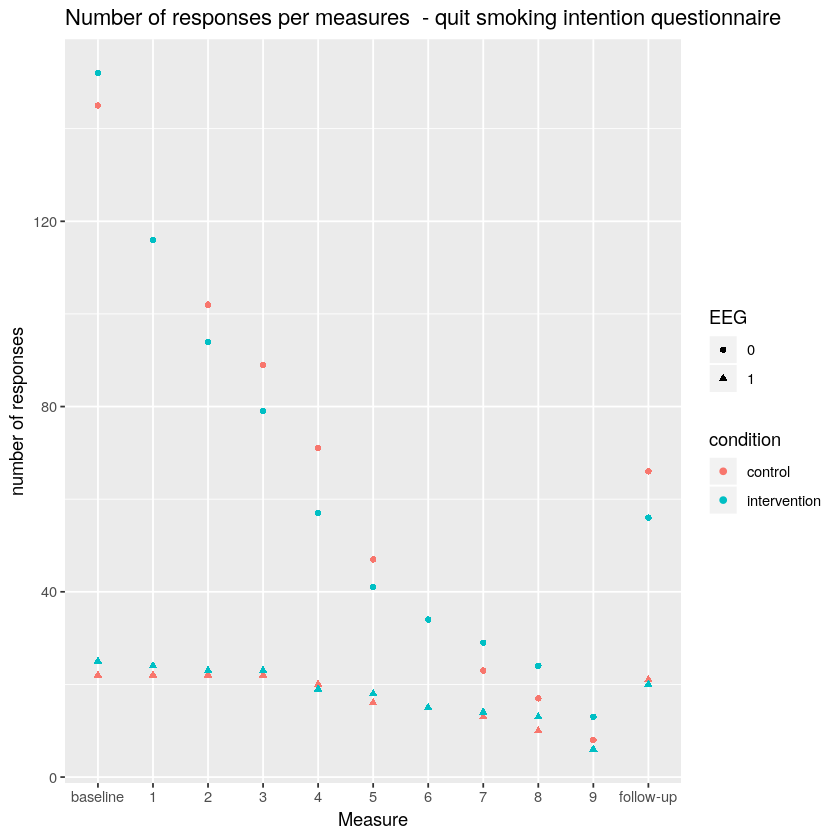

In [21]:
# count how many of each day per condition
n_rep <- df %>% group_by(condition, n_day, EEG) %>%
 summarize(count=n()) 
n_rep <-n_rep %>% drop_na()

n_rep$EEG<-as.factor(n_rep$EEG)


# plot
ggplot(data= n_rep, aes(x = n_day, y=count)) +
  geom_point(mapping = aes(colour = condition, shape=EEG) ) +
  ggtitle("Number of responses per measures  - quit smoking intention questionnaire")+
  xlab('Measure')+ ylab('number of responses')#+ 
 ggsave('nresp_per_day.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

 

In [22]:
df2<-df

In [23]:
head(df2)

ID,Good,condition,EEG,date,QuitInt,type,n_day
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<fct>,<fct>
702,1,intervention,0,2019-07-16 00:48:54,8,every3days,1
702,1,intervention,0,2019-07-16 11:30:50,NA,every3days,2
702,1,intervention,0,2019-07-21 23:27:25,6,every3days,3
702,1,intervention,0,2019-07-25 01:59:41,6,every3days,4
702,1,intervention,0,2019-07-28 01:49:46,6,every3days,5
702,1,intervention,0,2019-08-03 15:02:46,6,every3days,6


In [26]:
df2<-rename(df2, score_QuitInt=QuitInt)

In [ ]:
df2 %>% group_by(condition, n_day) %>% 
    count() 
    
    

In [29]:
# turn df into long format 
df2_long<-df2 %>% 
  pivot_longer(
    -c('ID', 'condition','type', 'n_day', 'EEG', 'Good', 'date'),  
    names_to = c(".value", "value"), 
    names_sep = "_", 
    values_drop_na = TRUE
  )

In [30]:
head(df2_long)

ID,Good,condition,EEG,date,type,n_day,value,score
<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>,<fct>,<chr>,<dbl>
702,1,intervention,0,2019-07-16 00:48:54,every3days,1,QuitInt,8
702,1,intervention,0,2019-07-21 23:27:25,every3days,3,QuitInt,6
702,1,intervention,0,2019-07-25 01:59:41,every3days,4,QuitInt,6
702,1,intervention,0,2019-07-28 01:49:46,every3days,5,QuitInt,6
702,1,intervention,0,2019-08-03 15:02:46,every3days,6,QuitInt,6
702,1,intervention,0,2019-08-06 01:51:27,every3days,7,QuitInt,6


In [40]:
df2_long$ID<-as.factor(df2_long$ID)
length(levels(df2_long$ID))

[1] 341

In [31]:
# compute summary statistics per condition per day for each score
summary_df2<- df2_long %>%
  group_by(condition, n_day, value) %>%
  summarise(mean.total = mean(score),
            sd.total= sd(score), count = n(),
            se.mean = sd.total/sqrt(count), 
            ci.mean= qt(1-(1-0.95/2),count-1)*se.mean) 
            

In [32]:
summary_df2

condition,n_day,value,mean.total,sd.total,count,se.mean,ci.mean
<chr>,<fct>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
control,baseline,QuitInt,3.898204,1.235200,167,0.09558266,-0.006002750
control,1,QuitInt,4.231343,1.256048,134,0.10850603,-0.006816916
control,2,QuitInt,4.372881,1.319133,118,0.12143607,-0.007631218
control,3,QuitInt,4.382353,1.400453,102,0.13866555,-0.008716904
control,4,QuitInt,4.600000,1.396625,90,0.14721722,-0.009257587
control,5,QuitInt,4.806452,1.502334,62,0.19079658,-0.012013566
control,6,QuitInt,4.833333,1.534474,48,0.22148222,-0.013962797
control,7,QuitInt,5.000000,1.352247,36,0.22537447,-0.014234205
control,8,QuitInt,4.840000,1.624808,25,0.32496154,-0.020591460


In [ ]:
# with EEG option compute summary statistics per condition per day for each score
summary_df2_eeg <- df2_long %>%
  group_by(condition, n_day, score, EEG) %>%
  summarise(mean.total = mean(value),
            sd.total= sd(value), count = n(),
            se.mean = sd.total/sqrt(count), 
            ci.mean= qt(1-(1-0.95/2),count-1)*se.mean)

In [ ]:
summary_df2_eeg$EEG<-as.factor(summary_df2_eeg$EEG)

Saving 6.67 x 6.67 in image



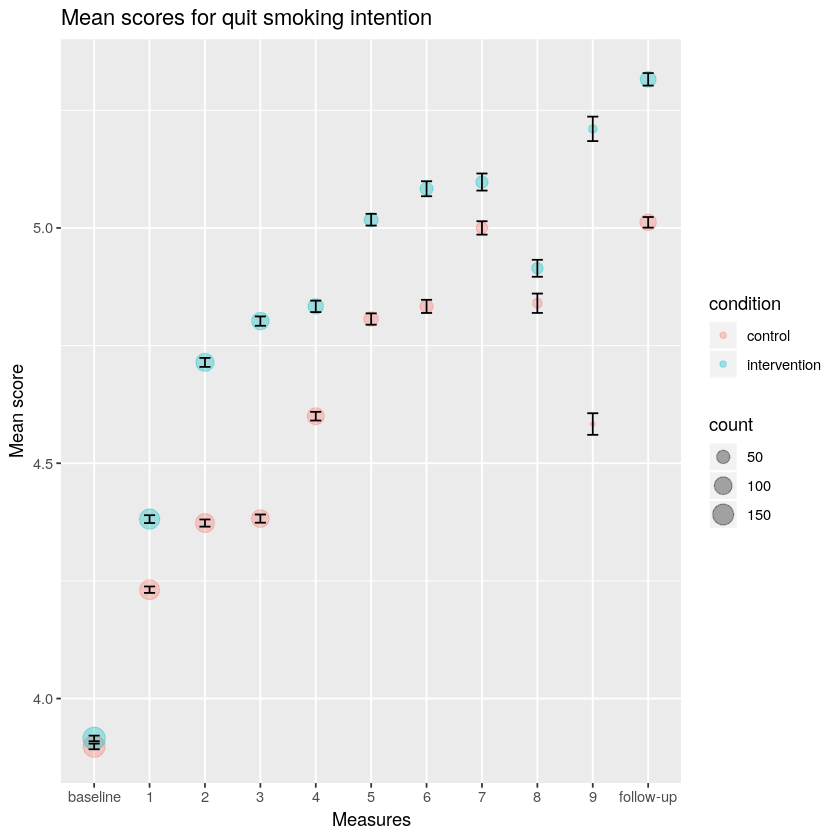

In [33]:
# no EEG variable
ggplot(data=summary_df2, mapping=aes(x= n_day, y=mean.total)) +
      geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
       geom_errorbar(aes(ymin = mean.total - ci.mean, ymax = mean.total + ci.mean), 
                width=0.2)+
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Measures")+ylab("Mean score")+
   ggtitle("Mean scores for quit smoking intention")

  ggsave('quit_int.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
# EEG variable

ggplot(data=summary_df2_eeg, mapping=aes(x= n_day, y=mean.total)) +
      geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
        facet_wrap(~EEG)+
       geom_errorbar(aes(ymin = mean.total - ci.mean, ymax = mean.total + ci.mean), 
                width=0.2)+
     theme(panel.spacing.x=unit(2, "cm"),panel.spacing.y=unit(1, "lines")) +
 theme(axis.text.x = element_text(angle = 90, hjust = 1))+
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Measures")+ylab("Mean score")+
   ggtitle("Mean scores for quit smoking intention")

  ggsave('quit_int_eeg_var.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [34]:
library(cowplot)
library(readr)

source("~/Documents/RainCloudPlots/tutorial_R/R_rainclouds.R")
source("~/Documents/RainCloudPlots/tutorial_R/summarySE.R")

theme_set(theme_cowplot())


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [35]:
df3<-df2

In [36]:
which(is.na(df3$n_day))

integer(0)

In [ ]:
df3<-drop_na(df3, n_day)

In [ ]:
head(df3)

Warning message:
“Removed 59 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 59 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 59 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 59 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 59 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 59 rows containing missing values (geom_point).”


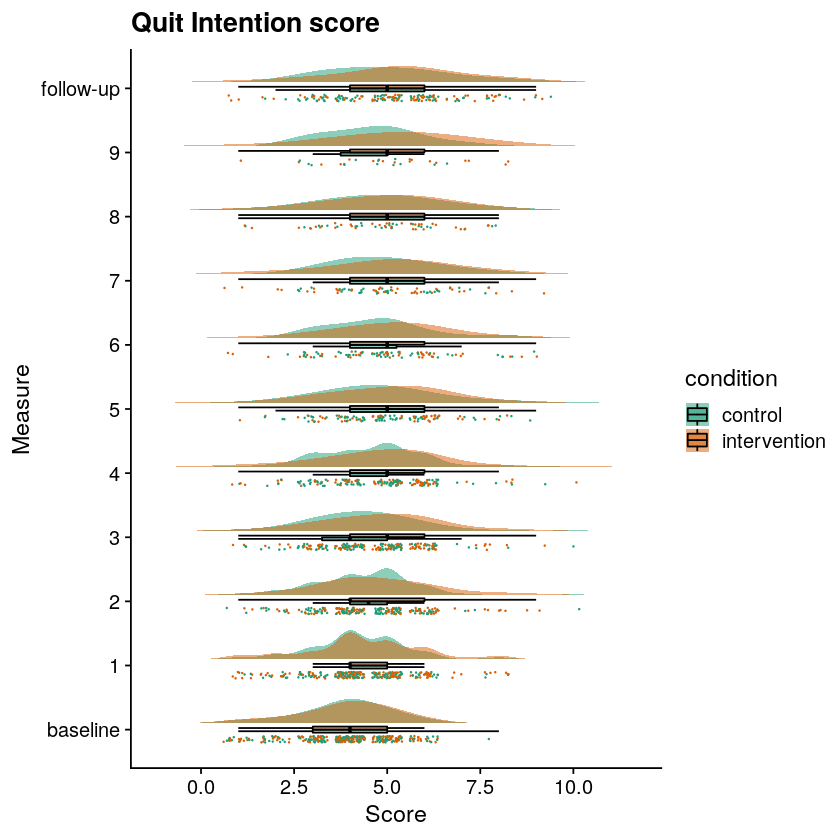

In [38]:
ggplot(df3, aes(x = n_day, y = score_QuitInt, fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = score_QuitInt, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = score_QuitInt,  fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
 # geom_line(data = sumrepdat, aes(x = as.numeric(condition)+.1, y = score_mean, group = time, colour = time), linetype = 3)+
 # geom_point(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time), shape = 18) +
 # geom_errorbar(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time, ymin = score_mean-se, ymax = score_mean+se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")+
  xlab('Measure') + ylab('Score')+
  ggtitle("Quit Intention score") +
  coord_flip()

ggsave('raincloud_quit_int_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)